## **GENERATION OF KD -TREE**

C:\Users\admin\AppData\Local\Temp\ipykernel_12396\1213761219.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["c_acctbal"] = filtered_df["c_acctbal"].round(0)
C:\Users\admin\AppData\Local\Temp\ipykernel_12396\1213761219.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["c_nationkey"] = filtered_df["c_nationkey"].round(0)


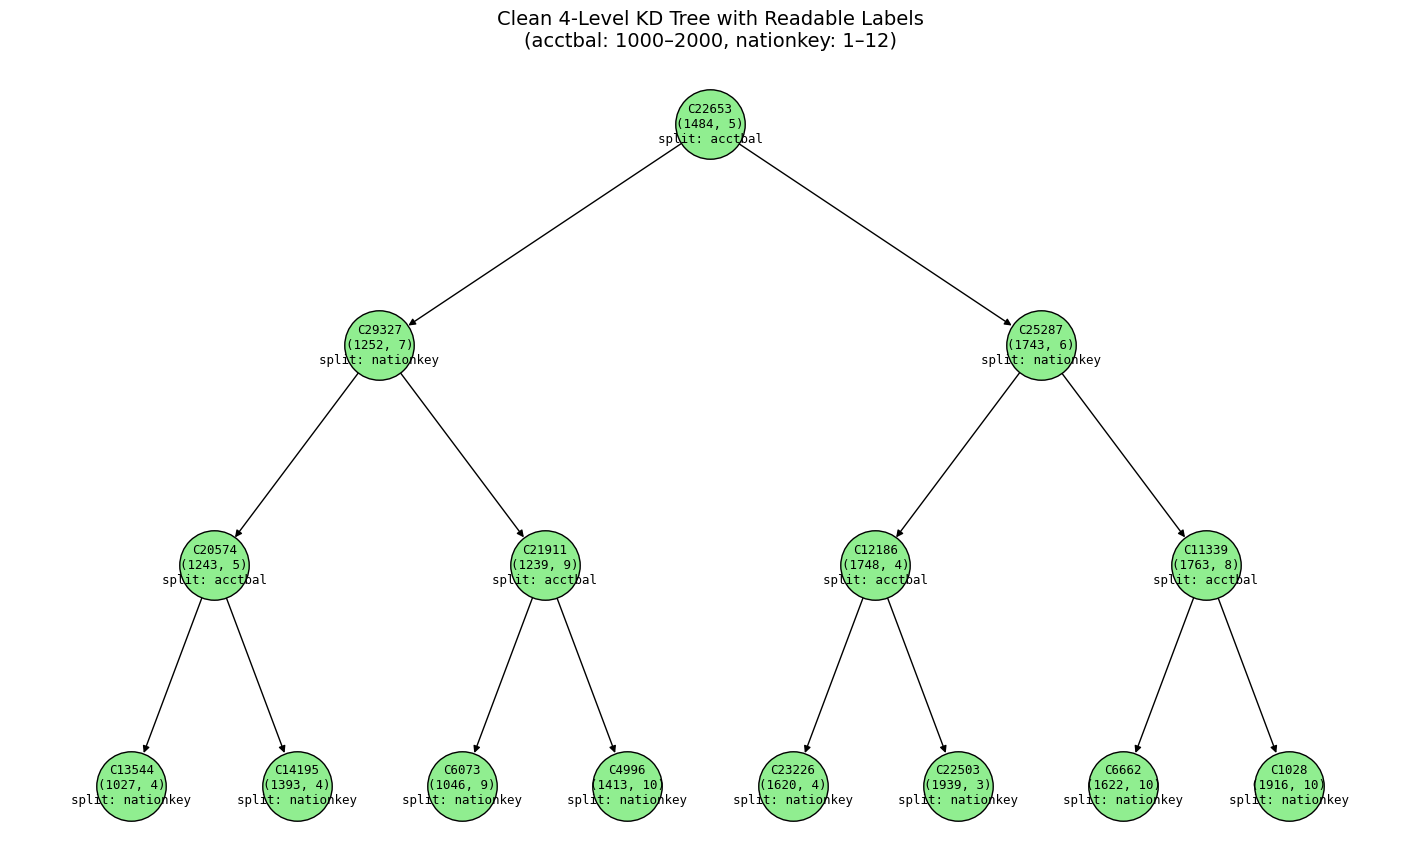

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Load customer data
customer_df = pd.read_csv("C:\\Users\\admin\\Desktop\\tpc-h\\customer.csv")

# Filter based on constraints
filtered_df = customer_df[
    (customer_df["c_acctbal"] >= 1000) & (customer_df["c_acctbal"] <= 2000) &
    (customer_df["c_nationkey"] >= 1) & (customer_df["c_nationkey"] <= 12)
]

# Round to integers for clarity
filtered_df["c_acctbal"] = filtered_df["c_acctbal"].round(0)
filtered_df["c_nationkey"] = filtered_df["c_nationkey"].round(0)

# Get points and labels
points = filtered_df[["c_acctbal", "c_nationkey"]].to_numpy()
labels = ["C" + str(k) for k in filtered_df["c_custkey"]]

# Define KDNode class
class KDNode:
    def __init__(self, point, label, axis, left=None, right=None):
        self.point = point
        self.label = label
        self.axis = axis
        self.left = left
        self.right = right

# Build the k-d tree
def build_kd_tree(points, labels, depth=0, max_depth=4):
    if len(points) == 0 or depth >= max_depth:
        return None

    axis = depth % 2
    sorted_idx = points[:, axis].argsort()
    points = points[sorted_idx]
    labels = [labels[i] for i in sorted_idx]
    median = len(points) // 2

    return KDNode(
        point=points[median],
        label=labels[median],
        axis=axis,
        left=build_kd_tree(points[:median], labels[:median], depth + 1, max_depth),
        right=build_kd_tree(points[median + 1:], labels[median + 1:], depth + 1, max_depth)
    )

# Plotting
def visualize_kd_tree(root):
    G = nx.DiGraph()
    pos = {}
    labels_dict = {}

    def add_edges(node, pos_x=0, pos_y=0, dx=1.0, depth=0):
        if node is None:
            return
        name = f"{node.label}\n({int(node.point[0])}, {int(node.point[1])})\nsplit: {'acctbal' if node.axis == 0 else 'nationkey'}"
        G.add_node(name)
        pos[name] = (pos_x, -pos_y)
        labels_dict[name] = name

        if node.left:
            left_name = f"{node.left.label}\n({int(node.left.point[0])}, {int(node.left.point[1])})\nsplit: {'acctbal' if node.left.axis == 0 else 'nationkey'}"
            G.add_edge(name, left_name)
            add_edges(node.left, pos_x - dx, pos_y + 1, dx / 2, depth + 1)

        if node.right:
            right_name = f"{node.right.label}\n({int(node.right.point[0])}, {int(node.right.point[1])})\nsplit: {'acctbal' if node.right.axis == 0 else 'nationkey'}"
            G.add_edge(name, right_name)
            add_edges(node.right, pos_x + dx, pos_y + 1, dx / 2, depth + 1)

    add_edges(root)

    plt.figure(figsize=(14, 8))
    nx.draw(G, pos, with_labels=True, labels=labels_dict,
            node_size=2500, node_color="lightgreen", font_size=9,
            font_family="monospace", edgecolors="black")
    plt.title("Clean 4-Level KD Tree with Readable Labels\n(acctbal: 1000–2000, nationkey: 1–12)", fontsize=14)
    plt.axis("off")
    plt.show()

# Build and visualize
kd_tree_root = build_kd_tree(points, labels)
visualize_kd_tree(kd_tree_root)


## **PARTITION LAYOUT USING THE KD TREE**

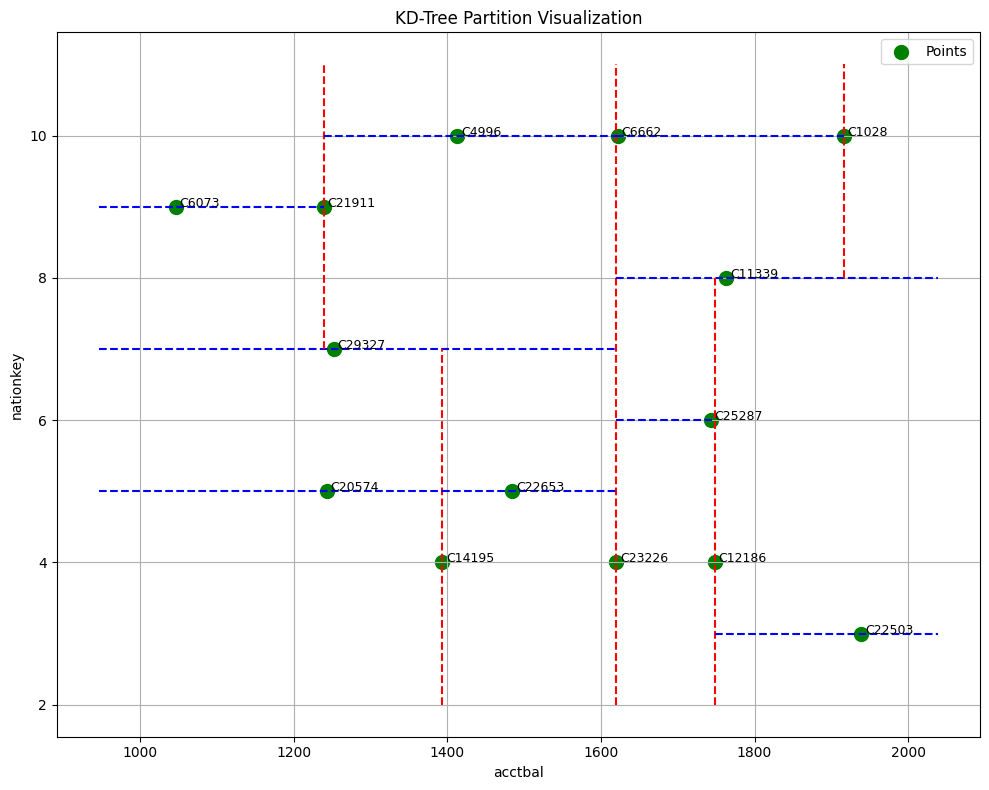

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Sample 2D points and labels
points = np.array([
    [1484, 5], [1252, 7], [1243, 5], [1393, 4], [1239, 9], [1046, 9], [1413, 10],
    [1743, 6], [1748, 4], [1620, 4], [1939, 3], [1763, 8], [1622, 10], [1916, 10]
])
labels = [
    "C22653", "C29327", "C20574", "C14195", "C21911", "C6073", "C4996",
    "C25287", "C12186", "C23226", "C22503", "C11339", "C6662", "C1028"
]

# Recursive KD-Tree splitting visualization
def plot_kd_tree(ax, points, depth=0, bounds=None):
    if len(points) == 0:
        return

    k = points.shape[1]
    axis = depth % k
    points = points[points[:, axis].argsort()]
    median_idx = len(points) // 2
    median_point = points[median_idx]

    # Draw the splitting line
    if bounds is None:
        bounds = [[min(points[:, 0])-100, max(points[:, 0])+100], [min(points[:, 1])-1, max(points[:, 1])+1]]

    if axis == 0:
        ax.plot([median_point[0], median_point[0]], bounds[1], 'r--')
        left_bounds = [[bounds[0][0], median_point[0]], bounds[1]]
        right_bounds = [[median_point[0], bounds[0][1]], bounds[1]]
    else:
        ax.plot(bounds[0], [median_point[1], median_point[1]], 'b--')
        left_bounds = [bounds[0], [bounds[1][0], median_point[1]]]
        right_bounds = [bounds[0], [median_point[1], bounds[1][1]]]

    # Recursively split
    plot_kd_tree(ax, points[:median_idx], depth + 1, left_bounds)
    plot_kd_tree(ax, points[median_idx + 1:], depth + 1, right_bounds)

# Plot the KD-tree splits
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(points[:, 0], points[:, 1], c='green', s=100, label="Points")
for i, label in enumerate(labels):
    ax.text(points[i, 0] + 5, points[i, 1], label, fontsize=9)

plot_kd_tree(ax, points)

ax.set_xlabel("acctbal")
ax.set_ylabel("nationkey")
ax.set_title("KD-Tree Partition Visualization")
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### **SHOW THE LABELS OUTSIDE THE NODE**

C:\Users\admin\AppData\Local\Temp\ipykernel_980\2385237716.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["c_acctbal"] = filtered_df["c_acctbal"].round(0)
C:\Users\admin\AppData\Local\Temp\ipykernel_980\2385237716.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["c_nationkey"] = filtered_df["c_nationkey"].round(0)


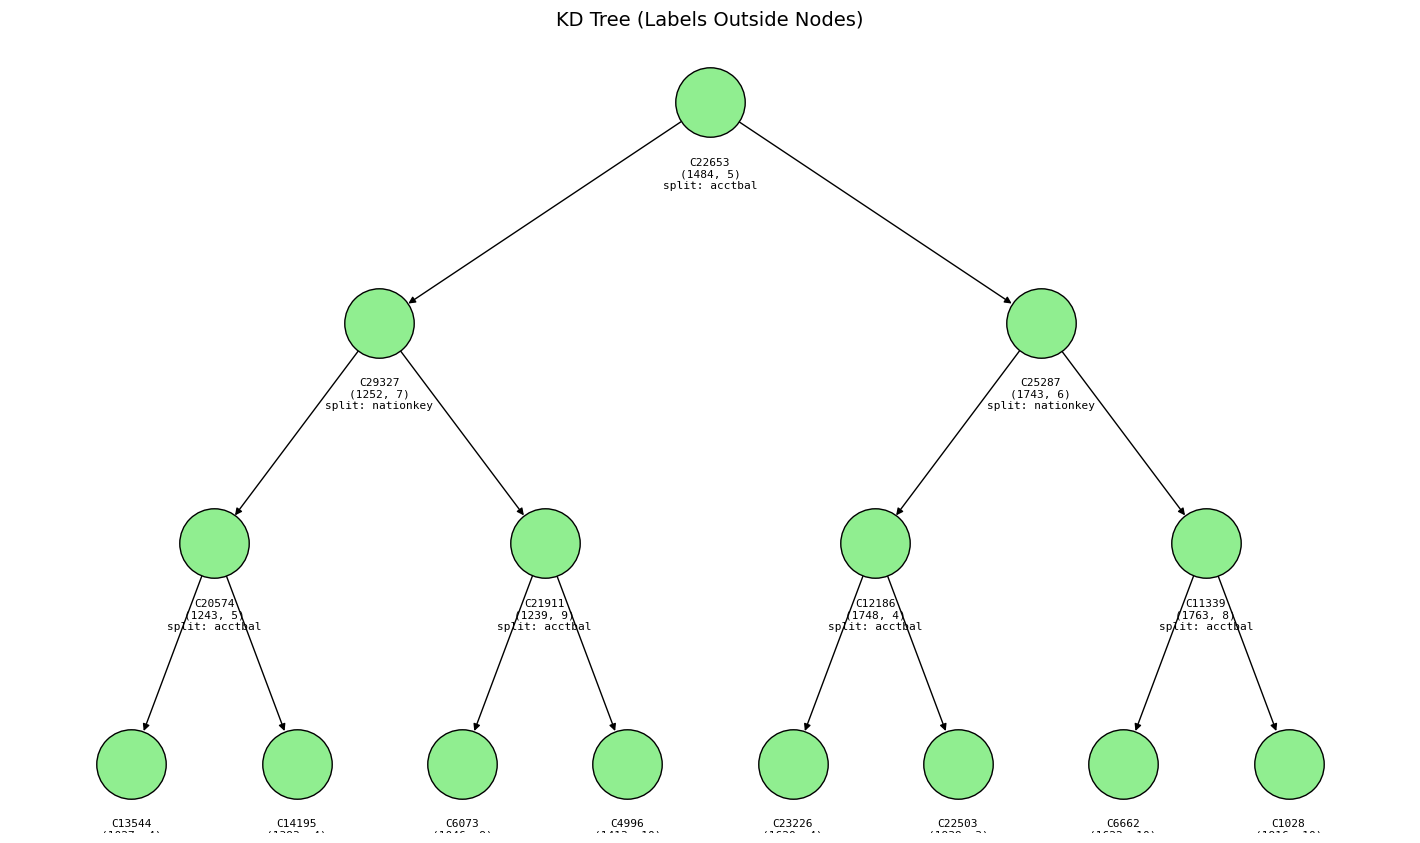

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Load customer data
customer_df = pd.read_csv("C:\\Users\\admin\\Desktop\\tpc-h\\customer.csv")

# Filter based on constraints
filtered_df = customer_df[
    (customer_df["c_acctbal"] >= 1000) & (customer_df["c_acctbal"] <= 2000) &
    (customer_df["c_nationkey"] >= 1) & (customer_df["c_nationkey"] <= 12)
]

# Round to integers for clarity
filtered_df["c_acctbal"] = filtered_df["c_acctbal"].round(0)
filtered_df["c_nationkey"] = filtered_df["c_nationkey"].round(0)

# Get points and labels
points = filtered_df[["c_acctbal", "c_nationkey"]].to_numpy()
labels = ["C" + str(k) for k in filtered_df["c_custkey"]]

# Define KDNode class
class KDNode:
    def __init__(self, point, label, axis, left=None, right=None):
        self.point = point
        self.label = label
        self.axis = axis
        self.left = left
        self.right = right

# Build the k-d tree
def build_kd_tree(points, labels, depth=0, max_depth=4):
    if len(points) == 0 or depth >= max_depth:
        return None

    axis = depth % 2
    sorted_idx = points[:, axis].argsort()
    points = points[sorted_idx]
    labels = [labels[i] for i in sorted_idx]
    median = len(points) // 2

    return KDNode(
        point=points[median],
        label=labels[median],
        axis=axis,
        left=build_kd_tree(points[:median], labels[:median], depth + 1, max_depth),
        right=build_kd_tree(points[median + 1:], labels[median + 1:], depth + 1, max_depth)
    )

# Visualize KD Tree with labels outside the node circles
def visualize_kd_tree_outside_labels(root):
    G = nx.DiGraph()
    pos = {}
    labels_dict = {}

    def add_edges(node, pos_x=0, pos_y=0, dx=1.0, depth=0):
        if node is None:
            return
        node_name = node.label
        label_text = f"{node.label}\n({int(node.point[0])}, {int(node.point[1])})\nsplit: {'acctbal' if node.axis == 0 else 'nationkey'}"
        
        G.add_node(node_name)
        pos[node_name] = (pos_x, -pos_y)
        labels_dict[node_name] = label_text

        if node.left:
            G.add_edge(node_name, node.left.label)
            add_edges(node.left, pos_x - dx, pos_y + 1, dx / 2, depth + 1)

        if node.right:
            G.add_edge(node_name, node.right.label)
            add_edges(node.right, pos_x + dx, pos_y + 1, dx / 2, depth + 1)

    add_edges(root)

    plt.figure(figsize=(14, 8))
    
    # Draw graph without labels
    nx.draw(G, pos, with_labels=False,
            node_size=2500, node_color="lightgreen",
            edgecolors="black")

    # Offset label positions slightly downward
    offset_labels = {k: (v[0], v[1] - 0.25) for k, v in pos.items()}
    nx.draw_networkx_labels(G, offset_labels, labels=labels_dict,
                            font_size=8, font_family="monospace",
                            verticalalignment="top")

    plt.title("KD Tree (Labels Outside Nodes)", fontsize=14)
    plt.axis("off")
    plt.show()

# Build and visualize the KD Tree
kd_tree_root = build_kd_tree(points, labels)
visualize_kd_tree_outside_labels(kd_tree_root)
